In [1]:
import numpy as np
import matplotlib.pyplot as plt


## Loading data

In [2]:
from coco_utils import load_coco_data, sample_coco_minibatch, decode_captions
from image_utils import image_from_url


In [3]:
data = load_coco_data(pca_features=False)

In [4]:
def show_image(batch_size):
    captions, features, urls = sample_coco_minibatch(data, batch_size=batch_size)
    for i, (caption, url) in enumerate(zip(captions, urls)):
        plt.imshow(image_from_url(url))
        plt.axis('off')
        caption_str = decode_captions(caption, data['idx_to_word'])
        plt.title(caption_str)
        plt.show()    

In [5]:
for k, v in data.items():
    if type(v) == np.ndarray:
        print(k, type(v), v.shape, v.dtype)
    else:
        print(k, type(v), len(v))

val_image_idxs <class 'numpy.ndarray'> (195954,) int32
train_urls <class 'numpy.ndarray'> (82783,) <U63
val_captions <class 'numpy.ndarray'> (195954, 17) int32
word_embedding <class 'numpy.ndarray'> (1004, 304) float64
word_to_idx <class 'dict'> 1004
val_features <class 'numpy.ndarray'> (40504, 4096) float32
train_features <class 'numpy.ndarray'> (82783, 4096) float32
train_image_idxs <class 'numpy.ndarray'> (400135,) int32
train_captions <class 'numpy.ndarray'> (400135, 17) int32
val_urls <class 'numpy.ndarray'> (40504,) <U63
idx_to_word <class 'list'> 1004


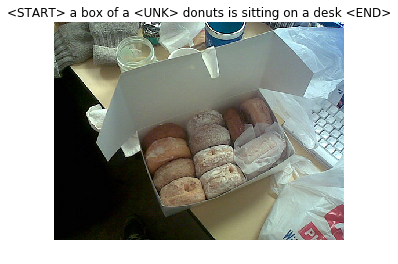

In [6]:
show_image(1)

In [7]:
def group_image_index_by_image_id(image_ids_in_caption_data_order):
    image_positions_by_image_id = {}
    for i, img_id in enumerate(image_ids_in_caption_data_order):
        if img_id in image_positions_by_image_id:
            image_positions_by_image_id[img_id].append(i)
        else:
            image_positions_by_image_id[img_id] = [i]
    return image_positions_by_image_id

def map_image_index_to_captions(caption_data, grouped_image_index):
    captions_by_image_id = {}
    for k, v in grouped_image_index.items():
        captions_by_image_id[k] = caption_data[v]
    return captions_by_image_id

def scramble_image_caption_pairs(caption_data, grouped_image_index):
    to_shuffle_caption = np.copy(caption_data)
    np.random.shuffle(to_shuffle_caption)
    return map_image_index_to_captions(to_shuffle_caption, grouped_image_index)

def flatten_image_caption_groups(grouped_captions):
    all_captions = []
    all_image_ids = []
    for k, v in grouped_captions.items():
        all_image_ids += [k] * len(v) # duplicate lables
        all_captions.append(v)
    flat_image_ids = np.array(all_image_ids)
    flat_captions = np.concatenate(all_captions, axis=0)
    assert flat_image_ids.shape[0] == flat_captions.shape[0]
    return flat_image_ids, flat_captions

def merge_demo_sampled(demo_image, demo_caption, sample_image, sample_caption):
    is_demo = np.ones(demo_image.shape)
    is_sample = np.ones(sample_image.shape) * -1
    return np.concatenate([demo_image, sample_image], axis=0), np.concatenate([demo_caption, sample_caption], axis=0), np.concatenate([is_demo, is_sample], axis=0)

def remove_start_token(captions_with_start_token):
    return np.array([c[1:] for c in captions_with_start_token])


In [8]:
# minibatch
class MiniBatcher(object):
    def __init__(self, batchable_tuple):
        shapes = [b.shape[0] for b in batchable_tuple]
        assert all([s == shapes[0] for s in shapes]), "Data to be batched together should have the same first dimension"
        self.batchable_tuple = batchable_tuple
        self.data_size = shapes[0]
    
    def sample(self, batch_size=100):
        assert batch_size <= self.data_size
        mask = np.random.choice(self.data_size, batch_size)
        batch_list = [b[mask] for b in self.batchable_tuple]
        return tuple(batch_list)

In [9]:
image_ids = data['train_image_idxs']
captions = data['train_captions']
idx_to_word = data['idx_to_word']

# create random pairing
grouped_image_index = group_image_index_by_image_id(image_ids)
grouped_captions = map_image_index_to_captions(captions, grouped_image_index)
scrambled_captions = scramble_image_caption_pairs(captions, grouped_image_index)

# merge both, and retain flag
image_idx_demo, captions_demo = flatten_image_caption_groups(grouped_captions)
image_idx_sampled, caption_sampled = flatten_image_caption_groups(scrambled_captions)
merged_image_idx, merged_captions, demo_or_sampled = merge_demo_sampled(image_idx_demo, captions_demo, image_idx_sampled, caption_sampled)
merged_captions = remove_start_token(merged_captions)

discri_batcher = MiniBatcher((merged_image_idx, merged_captions, demo_or_sampled))

In [10]:
import tensorflow as tf
import matplotlib.pyplot as plt
import layer_utils 

## Model Param

In [11]:

## word preprocess
vocab_dim = len(data['word_to_idx'])
image_feature_dim = data['val_features'].shape[1]
enable_preprocessed_embedding = True

if enable_preprocessed_embedding:
    word_embedding_dim = data['word_embedding'].shape[1]
else:
    word_embedding_dim = 256

START_TOKEN = '<START>'
END_TOKEN = '<END>'
NULL_TOKEN = '<NULL>'
NULL_ID = data['word_to_idx'][NULL_TOKEN]
START_ID = data['word_to_idx'][START_TOKEN]
END_ID = data['word_to_idx'][END_TOKEN]

## model params
hidden_dim = 512
learning_rate = 1e-3

print("Vocab Dim: %i\nImage Feature Dim: %i\nWord Embedding Dim: %i"%(vocab_dim, image_feature_dim, word_embedding_dim))

Vocab Dim: 1004
Image Feature Dim: 4096
Word Embedding Dim: 304


## Model Architecture

In [12]:
# Word Input
sy_caption_input = tf.placeholder(shape=[None, None], name="caption_input", dtype=tf.int32)

if enable_preprocessed_embedding:
    embedding_init = tf.constant(data['word_embedding'], dtype=tf.float32)
    embedding = tf.get_variable("embedding", initializer=embedding_init)
else:
    embedding_init = tf.random_normal_initializer()
    embedding = tf.get_variable("embedding", [vocab_dim, word_embedding_dim], dtype=tf.float32, initializer=embedding_init)

word_embedding = tf.nn.embedding_lookup(embedding, sy_caption_input)

# Image Input
sy_image_feat_input = tf.placeholder(shape=[None, image_feature_dim], name="image_feat_input", dtype=tf.float32)
image_projection = layer_utils.affine_transform(sy_image_feat_input, hidden_dim, 'image_proj')
initial_cell_state = image_projection * 0

# LSTM states
sy_hidden_state = tf.placeholder(shape=[None, hidden_dim], name="hidden_lstm_state", dtype=tf.float32)
sy_cell_state = tf.placeholder(shape=[None, hidden_dim], name="cell_lstm_state", dtype=tf.float32)

sy_is_initial_step = tf.placeholder(tf.int32, shape=[], name="is_initial_step")

initial_lstm_state = tf.nn.rnn_cell.LSTMStateTuple(image_projection * 0, image_projection)

In [13]:
# LSTM
cell = tf.nn.rnn_cell.LSTMCell(hidden_dim)
output_hidden_state, output_cell_state = tf.nn.dynamic_rnn(cell, word_embedding, time_major=False, dtype=tf.float32, initial_state=initial_lstm_state)
hidden_to_reward = tf.squeeze(layer_utils.affine_transform(output_hidden_state, 1, 'hidden_to_reward'), axis=2)


# Apply not-null mask to ignore reward on trailing padding
sy_not_null_mask = tf.placeholder(shape=[None, None], name="mask_not_null", dtype=tf.bool)
sy_is_demo = tf.placeholder(shape=[None], name="is_demo", dtype=tf.float32)
expanded_is_demo = tf.expand_dims(sy_is_demo, dim=1)
numeric_mask_not_null = tf.cast(sy_not_null_mask, dtype=tf.float32)
masked_reward = hidden_to_reward * numeric_mask_not_null
negated_sample_reward = expanded_is_demo * masked_reward # the higher reward to demo, the lower reward to sampled
total_not_null = tf.cast(tf.reduce_sum(numeric_mask_not_null, axis=1), tf.float32)
mean_reward_for_each_sentence = tf.reduce_sum(negated_sample_reward, axis=1) / total_not_null
mean_reward = tf.reduce_mean(mean_reward_for_each_sentence)

update_op = tf.train.AdamOptimizer(learning_rate).minimize(mean_reward * -1) # maximize the reward

print(output_hidden_state)
print("-- Input tensors --")
print("word embedding shape: ", word_embedding)
print("Hidden to reward layer: ", hidden_to_reward)

print("\n-- Loss tensors --")
print("Mask not null: ", numeric_mask_not_null)
print("Is demo null: ", sy_is_demo)
print("Total not null: ", total_not_null)
print("Masked reward: ", masked_reward)
print("Negated sample reward: ", masked_reward)
print("Mean reward for each sentence: ", masked_reward)
print("Mean reward: ",  mean_reward)


Tensor("rnn/transpose:0", shape=(?, ?, 512), dtype=float32)
-- Input tensors --
word embedding shape:  Tensor("embedding_lookup:0", shape=(?, ?, 304), dtype=float32)
Hidden to reward layer:  Tensor("Squeeze:0", shape=(?, ?), dtype=float32)

-- Loss tensors --
Mask not null:  Tensor("Cast:0", shape=(?, ?), dtype=float32)
Is demo null:  Tensor("is_demo:0", shape=(?,), dtype=float32)
Total not null:  Tensor("Sum:0", shape=(?,), dtype=float32)
Masked reward:  Tensor("mul_2:0", shape=(?, ?), dtype=float32)
Negated sample reward:  Tensor("mul_2:0", shape=(?, ?), dtype=float32)
Mean reward for each sentence:  Tensor("mul_2:0", shape=(?, ?), dtype=float32)
Mean reward:  Tensor("Mean:0", shape=(), dtype=float32)


## Training

In [14]:
sess = tf.InteractiveSession()
tf.global_variables_initializer().run()

In [19]:
def get_image_features(image_ids):
    return data['train_features'][image_ids]

def get_caption_mask(caption_data):
    return 

iter_num = 200
batch_size = 1000
for i in range(iter_num):
    image_idx_batch, caption_batch, demo_or_sampled_batch = discri_batcher.sample(batch_size=batch_size)
    image_feats_batch = get_image_features(image_idx_batch)
    not_null_mask = caption_batch != NULL_ID
    _, r, m, me = sess.run([update_op, mean_reward, masked_reward, mean_reward_for_each_sentence], feed_dict=
                       {sy_image_feat_input: image_feats_batch,
                        sy_caption_input: caption_batch, 
                        sy_not_null_mask: not_null_mask,
                        sy_is_demo: demo_or_sampled_batch
                       })
    print("iter {}, reward: {}".format(i,r))

iter 0, reward: 37.17100143432617
iter 1, reward: 38.454105377197266
iter 2, reward: 35.67890167236328
iter 3, reward: 39.143741607666016
iter 4, reward: 38.513702392578125
iter 5, reward: 39.1079216003418
iter 6, reward: 41.117427825927734
iter 7, reward: 37.916011810302734
iter 8, reward: 40.838748931884766
iter 9, reward: 40.46083450317383
iter 10, reward: 36.79372787475586
iter 11, reward: 42.04559326171875
iter 12, reward: 40.50257873535156
iter 13, reward: 38.55857467651367
iter 14, reward: 39.410804748535156
iter 15, reward: 38.68678665161133
iter 16, reward: 42.179264068603516
iter 17, reward: 36.96883773803711
iter 18, reward: 42.436500549316406
iter 19, reward: 42.02640914916992
iter 20, reward: 46.65012741088867
iter 21, reward: 49.51778793334961
iter 22, reward: 40.113563537597656
iter 23, reward: 41.26148986816406
iter 24, reward: 44.45432662963867
iter 25, reward: 41.84765625
iter 26, reward: 43.008724212646484
iter 27, reward: 49.42728805541992
iter 28, reward: 43.888053

In [20]:
def examine_batch_results(demo_or_sample, image_id, caption_batch, reward_per_token, mean_reward):
    num_to_examine = 10
    def examine(chosen_img, chosen_caption, chosen_reward_per_token, chosen_mean_reward, is_demo):
        for (img, cap, r, me_r) in zip(chosen_img, chosen_caption, chosen_reward_per_token, chosen_mean_reward):
            print("Avg reward: ", me_r * is_demo)
            plt.imshow(image_from_url(data['train_urls'][img]))
            plt.axis('off')
            plt.show()   
            decoded = decode_captions(cap, idx_to_word).split()
            for (i,j) in zip(decoded, r):
                print("{:<15} {}".format(i, j))
                
            print("- - - -")
    
    def examine_sample(chosen, is_demo):
        chosen_img = image_id[chosen]
        chosen_cap = caption_batch[chosen]
        chosen_reward_per_token = reward_per_token[chosen]
        chosen_mean_reward = mean_reward[chosen]
        
        examine(chosen_img, chosen_cap, chosen_reward_per_token, chosen_mean_reward, is_demo)
    
    print("DEMO RESULTS")    
    chosen = np.random.choice(np.where( demo_or_sampled_batch == 1 )[0], num_to_examine)
    examine_sample(chosen, 1)
    print("\n\nSAMPLED RESULTS")
    chosen = np.random.choice(np.where( demo_or_sampled_batch == -1 )[0], num_to_examine)
    examine_sample(chosen, -1)


DEMO RESULTS
Avg reward:  179.136184692


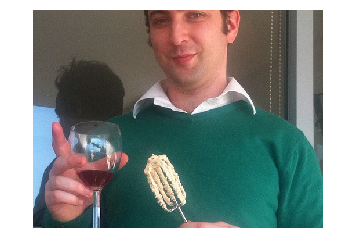

a               -23.989484786987305
man             -12.722440719604492
holds           80.60610961914062
a               158.0824432373047
glass           189.7410430908203
in              212.677978515625
one             218.93040466308594
hand            216.7947235107422
and             223.72720336914062
a               229.69879150390625
<UNK>           209.06829833984375
<UNK>           217.25880432128906
in              230.64256286621094
the             231.63572692871094
other           222.5367431640625
<END>           261.489990234375
- - - -
Avg reward:  166.648620605


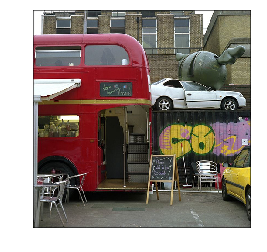

a               14.550119400024414
double          36.52609634399414
decker          62.13424301147461
bus             122.9389877319336
is              183.3690185546875
near            217.5255584716797
a               228.6012725830078
sign            224.6153564453125
graffiti        217.76925659179688
and             230.2933349609375
cars            221.94000244140625
<END>           239.52017211914062
- - - -
Avg reward:  166.648620605


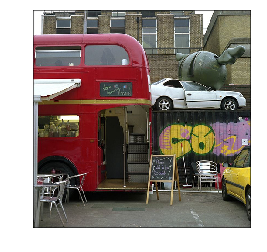

a               14.550119400024414
double          36.52609634399414
decker          62.13424301147461
bus             122.9389877319336
is              183.3690185546875
near            217.5255584716797
a               228.6012725830078
sign            224.6153564453125
graffiti        217.76925659179688
and             230.2933349609375
cars            221.94000244140625
<END>           239.52017211914062
- - - -
Avg reward:  165.285980225


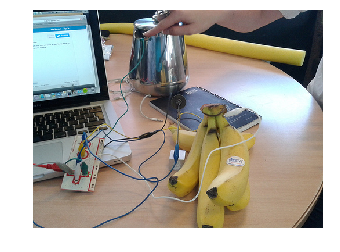

a               19.30443572998047
bunch           42.45539093017578
of              92.00393676757812
bananas         124.70289611816406
and             187.20901489257812
a               217.2918701171875
laptop          211.65972900390625
on              228.91552734375
a               228.02020263671875
table           215.7883758544922
<END>           250.7943572998047
- - - -
Avg reward:  167.864624023


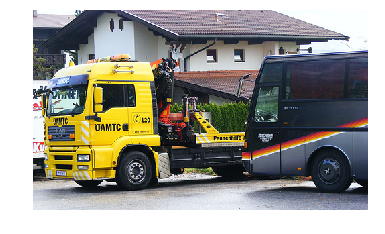

a               15.513564109802246
<UNK>           34.1368522644043
truck           89.7189712524414
parked          179.0936279296875
next            215.3067626953125
to              227.00279235839844
a               232.1556854248047
tour            221.96665954589844
bus             224.34902954101562
<END>           239.40225219726562
- - - -
Avg reward:  149.46031189


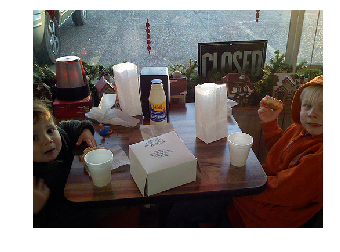

a               -20.778034210205078
little          -20.774946212768555
kid             38.224727630615234
sitting         106.69629669189453
at              170.6072235107422
a               202.16482543945312
table           209.52284240722656
with            223.6298828125
donuts          197.8450927734375
and             221.91522216796875
drinks          213.1884765625
<END>           251.28199768066406
- - - -
Avg reward:  -33.5902481079


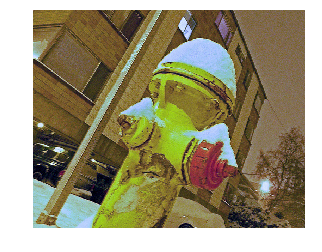

a               -3.9691007137298584
closeup         21.32404899597168
of              97.43748474121094
a               156.91989135742188
fire            135.7478790283203
hydrant         88.41344451904297
with            -14.289966583251953
snow            -105.11685943603516
on              -208.42471313476562
it              -259.23651123046875
<END>           -278.29833984375
- - - -
Avg reward:  111.209373474


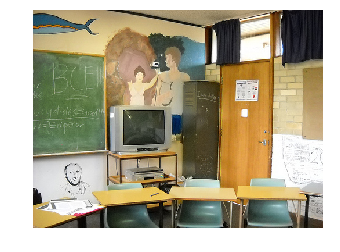

a               3.424299955368042
<UNK>           36.10300064086914
area            72.00163269042969
with            48.67449951171875
<UNK>           30.0792236328125
television      88.8402328491211
and             168.61734008789062
wooden          203.60415649414062
door            212.74940490722656
<END>           248.0
- - - -
Avg reward:  174.844146729


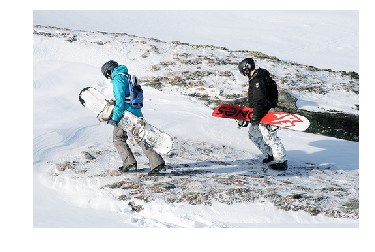

two             20.44816780090332
people          40.829864501953125
holding         116.49767303466797
snow            171.25289916992188
boards          208.15159606933594
walking         216.74928283691406
on              228.18270874023438
a               231.6787109375
snowy           222.63037109375
surface         226.7027587890625
<END>           240.16162109375
- - - -
Avg reward:  139.933135986


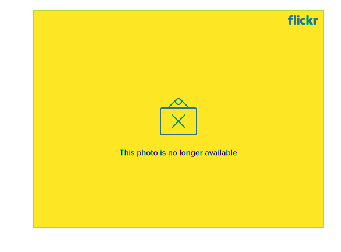

this            18.520034790039062
is              19.80133628845215
men             15.259048461914062
riding          107.82012939453125
boards          190.47335815429688
in              221.62765502929688
the             230.87620544433594
snow            218.3199005126953
<END>           236.70050048828125
- - - -


SAMPLED RESULTS
Avg reward:  176.154205322


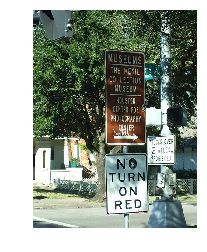

a               13.673705101013184
sidewalk        29.94084358215332
is              113.64764404296875
<UNK>           187.68844604492188
with            221.1345672607422
leaves          217.8780975341797
on              232.32015991210938
a               232.50440979003906
rainy           222.54443359375
day             226.57394409179688
<END>           239.79000854492188
- - - -
Avg reward:  182.593704224


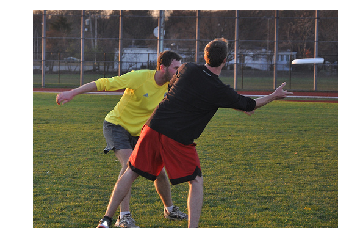

four            11.360061645507812
men             26.4243221282959
carrying        132.36041259765625
a               205.95379638671875
long            216.5137939453125
board           225.16458129882812
that            228.58914184570312
<UNK>           220.4988250732422
at              228.536865234375
the             234.26568603515625
<UNK>           220.00694274902344
<END>           241.4501953125
- - - -
Avg reward:  -206.686706543


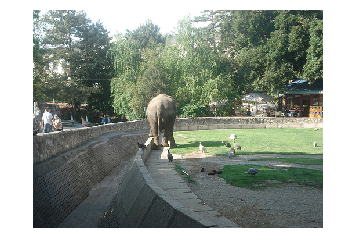

a               18.88872528076172
man             -17.794729232788086
is              -121.76148223876953
<UNK>           -213.57794189453125
through         -267.76617431640625
traffic         -273.86932373046875
<UNK>           -275.349853515625
on              -282.0801086425781
a               -282.4648742675781
skateboard      -274.53289794921875
<END>           -283.2449951171875
- - - -
Avg reward:  -140.648834229


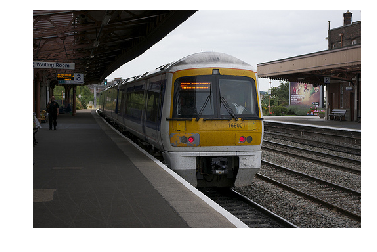

a               16.156696319580078
<UNK>           32.294673919677734
of              50.44251251220703
broccoli        -12.951127052307129
<UNK>           -154.16098022460938
in              -242.6996612548828
a               -273.6500244140625
broccoli        -262.1242980957031
row             -276.59423828125
<END>           -283.20184326171875
- - - -
Avg reward:  -175.690734863


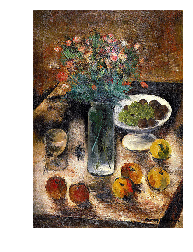

a               13.983890533447266
pizza           13.939934730529785
that            -68.0569076538086
<UNK>           -184.45877075195312
has             -253.17767333984375
three           -271.35906982421875
pieces          -269.5181884765625
left            -279.317626953125
<END>           -283.2522888183594
- - - -
Avg reward:  -227.560012817


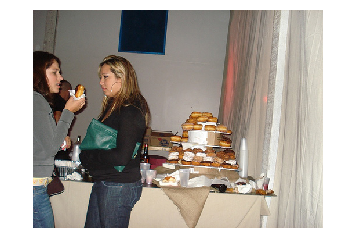

a               -33.80533981323242
town            -79.86900329589844
street          -190.9454803466797
features        -253.9619598388672
several         -272.95233154296875
vehicles        -270.052978515625
on              -280.4460754394531
a               -281.94000244140625
rainy           -277.1395263671875
day             -278.79583740234375
<END>           -283.25152587890625
- - - -
Avg reward:  -211.885787964


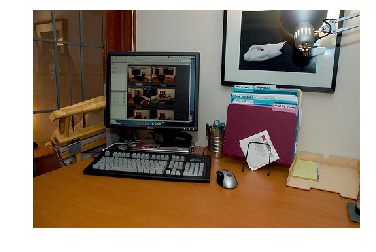

some            12.661324501037598
dogs            -17.852495193481445
and             -164.64794921875
a               -249.8104705810547
cat             -243.57017517089844
are             -274.9532165527344
sleeping        -267.6177978515625
on              -281.37255859375
a               -282.4874267578125
<UNK>           -277.28009033203125
<END>           -283.81280517578125
- - - -
Avg reward:  -134.363357544


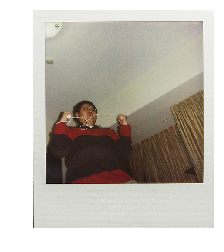

a               8.05677318572998
man             -8.427729606628418
in              18.860519409179688
a               102.0936279296875
baseball        58.516380310058594
uniform         -85.94220733642578
<UNK>           -197.83209228515625
a               -261.4561767578125
baseball        -259.0230712890625
in              -278.1889953613281
the             -282.0750427246094
field           -277.91339111328125
<END>           -283.3922119140625
- - - -
Avg reward:  193.060348511


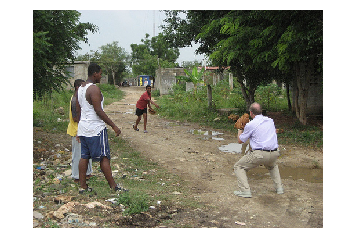

a               11.304360389709473
man             23.64811134338379
riding          125.83768463134766
a               202.60804748535156
skateboard      210.6255340576172
at              222.9141845703125
a               231.76669311523438
skate           217.0213623046875
park            222.1387939453125
up              225.36871337890625
the             233.38906860351562
side            231.2121124267578
of              228.06202697753906
a               234.3324737548828
ramp            228.45574951171875
<END>           240.28082275390625
- - - -
Avg reward:  -170.587860107


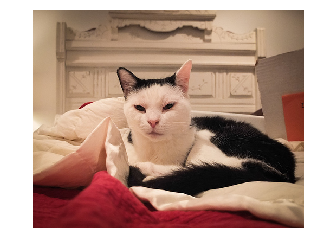

oranges         -35.166839599609375
are             -63.08318328857422
sitting         -86.93736267089844
on              -123.66246795654297
a               -195.900634765625
wooden          -227.61358642578125
cutting         -247.8282470703125
board           -273.16375732421875
<END>           -281.9346923828125
- - - -


In [21]:
examine_batch_results(demo_or_sampled_batch, image_idx_batch, caption_batch, m, me)